#Introduction

In this notebook we will use a clustering algorithm to analyze our data (i.e. YouTube comments of a single video).
This will help us extract topics of discussion.
We use the embeddings generated in Assignment 4 as input. 
(This notebook will not run without first running the assignment 4 Notebook, as it relies on the data in the folder 'output/')
Each of our comments has been assigned a vector that encodes information about its meaning.
The closer two vectors are, the more similar the meaning.

Each vector is of 512 Dimensions.

Before we can cluster our data we need to reduce the embeddings' dimensionality to overcome the curse of dimensionality.
We use the UMAP ALgorithm for this.

After that we use the KMedoids Algorithm to partition the embedding space and generate our clusters this way.

We need to define the number of clusters we want to have. 
To find the optimal number of clusters, we use a simple optimization scheme.

Once the clusters are created, we visualize them.
To do this we reduce the dimensionality of the embeddings again to two dimensions.
Then we render a scatterplot of our data.

Furthermore we want to analyze and interpret our clusters.
To do this, we:
- print some statistics about each of the clusters
- print cluster's medoid (the central sample)
- print the cluster(s) we want to analyze further

Check to see if jupyter lab uses the correct python interpreter with '!which python'.
It should be something like '/opt/anaconda3/envs/[environment name]/bin/python' (on Mac).
If not, try this: https://github.com/jupyter/notebook/issues/3146#issuecomment-352718675

In [1]:
!which python

/usr/local/bin/python


# Install dependencies:

In [2]:
install_packages = True
if install_packages:    
    !pip install umap-learn
    !pip install scikit-learn-extra

     |████████████████████████████████| 624kB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp36-cp36m-linux_x86_64.whl size=340356 sha256=f058b88c0bfeab7a96a6c45bbea4cb48272c8436bd3728a259651c864964b9e2
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


# Imports

In [3]:
#imports

import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import umap
from sklearn_extra.cluster import KMedoids
import seaborn as sns
#from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, OPTICS
from sklearn.metrics import silhouette_samples, silhouette_score, pairwise_distances

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Functions to Save and load manually

In [5]:
# Save and load your data after clustering

def save_results():
    data.to_pickle(output_path+'data_clustered'+'.pkl')
    
def load_results():
    data = pd.read_pickle(output_path+'data_clustered'+'.pkl')
    

In [7]:
# Set pandas print options
#This will improve readability of printed pandas dataframe.


In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Set global Parameters
Set your parameters here:

output_path: Files generated in this notebook will be saved here.

model_type: Define which model was used to produce the embeddings. (Check the name of the .npy-file containing the embeddings)

In [9]:
output_path = "/content/drive/My Drive/Mustererkennung_FUBerlin_2020/output/"
model_type = 'Transformer' #@param ['DAN','Transformer','Transformer_Multilingual']

# Load Data
Load the preprocessed data as a pandas dataframe.
And load the embeddings as a numpy ndarray (a matrix in our case).

In [10]:
data = pd.read_pickle(output_path+'data_preprocessed'+'.pkl')
labels_default = np.zeros(len(data.index))-1
data['label_manual'] = labels_default

In [11]:
embeddings = np.load(output_path+'/embeddings'+model_type+'.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

# Dimensionality reduction with UMAP

We reduce the number of dimensions of our embeddings to make possibly present clusters more pronounced. 
The number of dimensions (num_dimensions) depends on the number of samples

In [12]:
# Set the number of dimensions to reduce to
num_dimensions =100

reducer_clustering = umap.UMAP(n_neighbors=50, 
                     n_components=num_dimensions, 
                     metric='cosine', 
                     #n_epochs=200, 
                     learning_rate=.5,
                     init='spectral', 
                     min_dist=0,
                     #spread=5.0, 
                     #set_op_mix_ratio=1.0, 
                     #local_connectivity=1.0, 
                     #negative_sample_rate=5, 
                     #transform_queue_size=4.0, 
                     force_approximation_algorithm=True, 
                     unique=True)
embeddings_umap = reducer_clustering.fit_transform(embeddings)

# Optimize the Number of Clusters

n_clusters: 2 silhouette_avg: 0.55263215
n_clusters: 102 silhouette_avg: 0.31012973
n_clusters: 202 silhouette_avg: 0.29507595
n_clusters: 302 silhouette_avg: 0.27880904
n_clusters: 402 silhouette_avg: 0.27266178
n_clusters: 502 silhouette_avg: 0.2714302
n_clusters: 602 silhouette_avg: 0.27069548
n_clusters: 702 silhouette_avg: 0.27152687
n_clusters: 802 silhouette_avg: 0.2736369
n_clusters: 902 silhouette_avg: 0.27486825


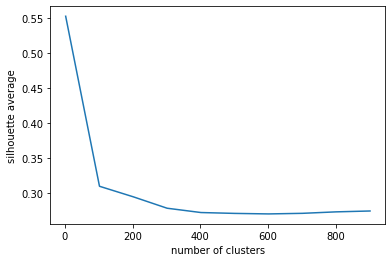

In [13]:
#optimize number of clusters
optimize_number_of_clusters = True#@param {type:'boolean'}

min_clusters=2 
max_clusters=1000 
step=100 

if optimize_number_of_clusters:
    rows_list = []
    inertias = []
    n_clusters = []
    silouette_scores = []
    init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
    random_state_param=1234 #@param {type:'number'}
    for i in range(min_clusters,max_clusters, step):
        temp_clustering = KMedoids(n_clusters=i, metric='euclidean', init=init_param, max_iter=200, random_state=random_state_param).fit(embeddings_umap)
        silhouette_avg = silhouette_score(embeddings_umap, temp_clustering.labels_)
        print("n_clusters:",i, "silhouette_avg:",silhouette_avg)
        silhouette_dict = {'number of clusters': i, 'silhouette average': silhouette_avg}
        rows_list.append(silhouette_dict)
    results = pd.DataFrame(rows_list)
    sns.lineplot(x = 'number of clusters', y = 'silhouette average',data = results)

# Clustering with KMedoids

In [27]:
number_of_clusters =  110
init_param = 'k-medoids++' #@param ['random', 'heuristic', 'k-medoids++']
clustering_model = KMedoids(n_clusters=number_of_clusters,
                            metric='cosine', 
                            init=init_param, 
                            max_iter=150, 
                            random_state=None).fit(embeddings_umap)
clustering_model
labels = clustering_model.labels_
data["label_kmedoids"] = labels
print("cluster","members", data["label_kmedoids"].value_counts().sort_values())

clustering_model.inertia_

medoids_indices = clustering_model.medoid_indices_

cluster members 13       3
18       6
80       8
79      10
41      10
109     11
59      11
71      11
72      13
105     14
61      15
103     15
87      16
65      18
99      18
69      20
98      20
68      21
94      22
108     22
97      23
43      23
22      23
82      23
28      24
75      24
35      24
77      25
95      26
30      26
20      26
24      28
54      28
107     28
56      29
63      29
89      29
92      30
106     30
51      30
74      30
53      30
96      30
40      32
100     33
62      33
19      33
93      35
8       35
52      35
76      36
91      36
57      36
14      37
17      39
88      39
55      40
70      40
85      41
6       41
29      42
47      42
46      42
15      45
37      45
73      46
26      46
38      46
78      47
104     48
81      49
101     51
66      51
23      51
16      51
83      52
0       52
102     55
33      56
49      57
86      58
27      59
31      59
2       59
4       59
48      59
60      60
21      61
11      63
58   

In [28]:
#calculate distances
distances = np.diag(pairwise_distances(X = clustering_model.cluster_centers_[labels], Y = embeddings_umap[:], metric='cosine'))
data["distance_kmedoids"] = distances

# Dimensionality Reduction for Visualization

In [29]:
num_dimensions =2

reducer_visualization = umap.UMAP(n_neighbors=50, 
                                  n_components=num_dimensions, 
                                  metric='cosine', 
                                  output_metric='euclidean', 
                                  #n_epochs=200, 
                                  learning_rate=.5,
                                  init='spectral', 
                                  min_dist=.1,
                                  spread=5.0, 
                                  set_op_mix_ratio=1.0, 
                                  local_connectivity=1.0, 
                                  negative_sample_rate=5, 
                                  transform_queue_size=4.0, 
                                  force_approximation_algorithm=True, 
                                  unique=True)
embeddings_umap_2d = reducer_visualization.fit_transform(embeddings)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1158: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


# Visualize clustering results

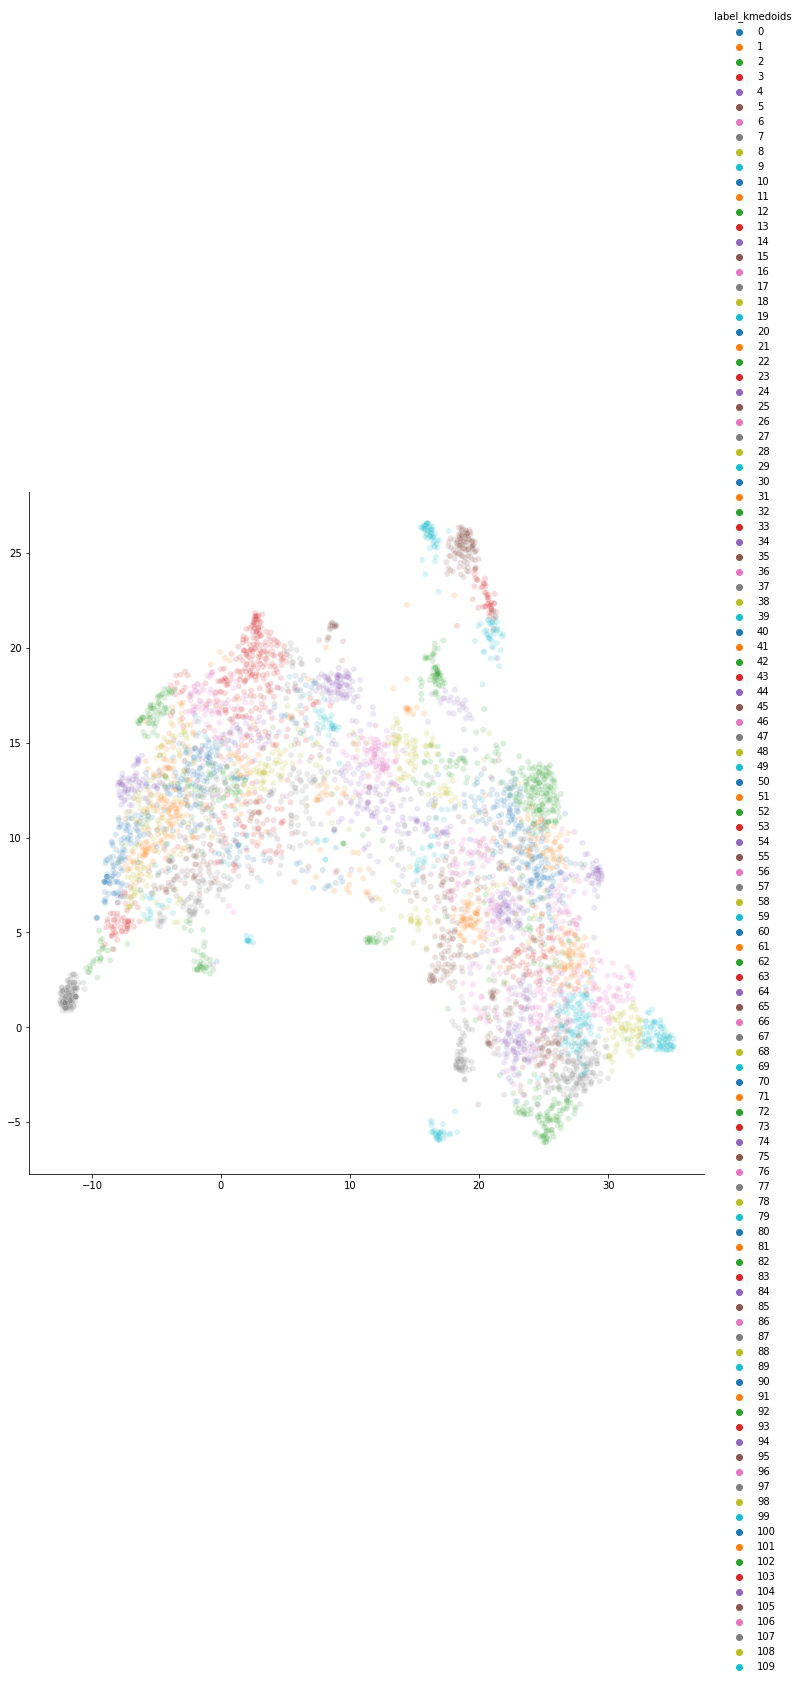

In [30]:
#@markdown Set the color palette used for visualizing different clusters
palette_param = "tab10" #@param ['Accent','cubehelix', "tab10", 'Paired', "Spectral"]
#@markdown Set opacity of data points (1 = opaque, 0 = invisible)
alpha_param = 0.16 #@param {type:"slider", min:0, max:1, step:0.01}


sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['label_kmedoids'], palette = palette_param,alpha = alpha_param,height = 10)


## Highlight one cluster

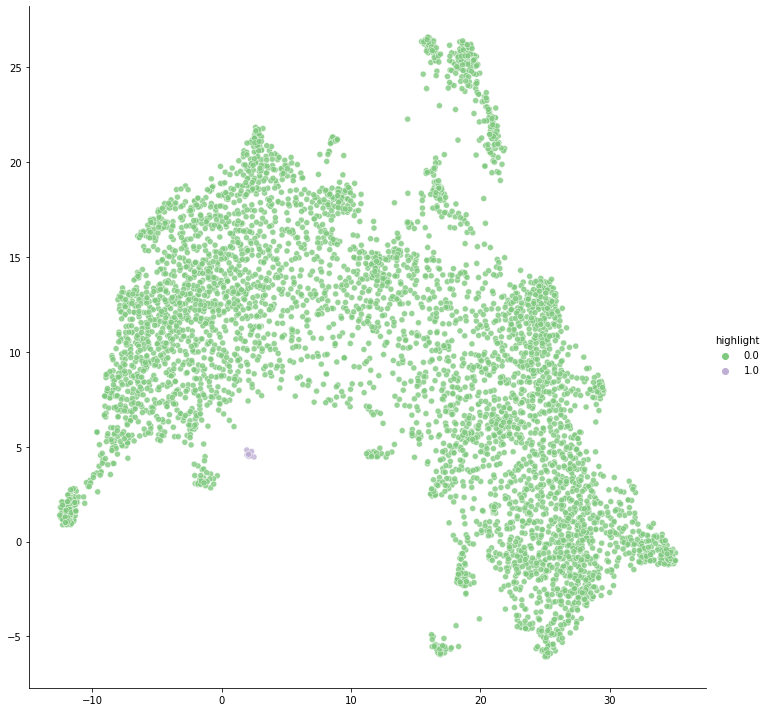

In [34]:
## Choose a cluster to higlight:
cluster_num = 79

data['highlight'] = np.zeros(len(data.index))
data.loc[data['label_kmedoids'] == cluster_num, 'highlight'] = 1

sns.relplot(x = embeddings_umap_2d[:, 0], y = embeddings_umap_2d[:, 1],  hue = data['highlight'], palette = "Accent",alpha = 0.8,height = 10)


# Print Medoids and cluster statistics

In [35]:
# print the medoids 
data.iloc[medoids_indices]      

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
3005,2016-08-18 15:03:28,greenjelly01,"Upped because of comment at <a href=""http://www.youtube.com/watch?v=CEii1_kEoZs&amp;t=2m51s"">2:51</a>.",0,Upped because of comment at 2:51.\n\n,-1.0,0,1.788139e-07,0.0
280,2020-05-14 18:22:57,sergio s,"@siouxperb5570 look, contrails are real,persistent contrails may be real too but make no mistake, chemtrails are also real. The fact that you don't ant to see doesn't make it unreal. You've been brainwashed and indoctrinated you poor creature. Enjoy life and go back to your beautiful bubble. Peace out.",1,"@ look, contrails are real,persistent contrails may be real too\nbut make no mistake, chemtrails are also real. The fact that you don't ant to\nsee doesn't make it unreal. You've been brainwashed and indoctrinated you poor\ncreature. Enjoy life and go back to your beautiful bubble. Peace out.\n\n",-1.0,1,0.000000e+00,0.0
3068,2016-08-18 15:57:30,TheSuave101,+Sid Grim alex jones lol what a fat ass.,1,+ alex jones lol what a fat ass.\n\n,-1.0,2,0.000000e+00,0.0
4502,2016-08-18 05:39:19,Azirahael,"@troubletr2 I have. all i found was ignorance and hope. Burden of proof. Where is your evidence? What are your sources? That which can be asserted without evidence, can be dismissed without evidence. So instead of telling us that there's evidence, present it.",1,"@ I have. all i found was ignorance and hope. Burden of proof. Where\nis your evidence? What are your sources? That which can be asserted without\nevidence, can be dismissed without evidence. So instead of telling us that\nthere's evidence, present it.\n\n",-1.0,3,1.788139e-07,0.0
766,2019-11-09 18:03:56,Sherri G.,"This video bought &amp; paid for by the elite...basically a tactic to make the people who actually know what&#39;s going on &amp; aren&#39;t oblivious to the evils of our govt to sound crazy. Well, guess it didn&#39;t work seeing how you got thousands more dislikes than likes. lol",0,"This video bought & paid for by the elite...basically a tactic to make the\npeople who actually know what's going on & aren't oblivious to the evils of\nour govt to sound crazy. Well, guess it didn't work seeing how you got\nthousands more dislikes than likes. lol\n\n",-1.0,4,0.000000e+00,0.0
2326,2016-08-24 05:06:07,Louis Maxwell,very poor investigative work tyt... thought u guys would get this one... sad...,0,very poor investigative work tyt... thought u guys would get this one...\nsad...\n\n,-1.0,5,0.000000e+00,0.0
4010,2016-08-18 03:13:49,qhsperson,"I was surprised when I was still teaching to find out how many students believed that we controlled the weather. In Texas, where he have tornadoes, floods, hurricanes, prolonged droughts, etc.<br />If we controlled the weather, would we need air conditioning?",0,"I was surprised when I was still teaching to find out how many students\nbelieved that we controlled the weather. In Texas, where he have tornadoes,\nfloods, hurricanes, prolonged droughts, etc. \nIf we controlled the weather, would we need air conditioning?\n\n",-1.0,6,0.000000e+00,0.0
4935,2016-08-18 02:17:21,RAIN DOG,last,0,last\n\n,-1.0,7,5.960464e-08,0.0
4214,2016-08-18 18:35:23,Dadee3,@Reel Deel says the guy responding to them? LMAOOOOO,1,@Reel Deel says the guy responding to them? LMAOOOOO\n\n,-1.0,8,0.000000e+00,0.0
1871,2017-03-14 16:15:16,Allee Oop,"76 of them are lying to you. My toilet collects the metal nanoparticles and surface tension shoves them to the edge of the water where they stack up. Be aware that Niosh filter masks can screen out these nanoparticles. Why are we being sprayed with them? Try these explanations: To avoid the destructive effects of a nuclear weapon, fire it off miles high in the sky, creating an EMP pulse which generates high currents in metal objects. But<br />before that event, soak the area with nanoparticles of metal over time and all living things will absorb them. Then when the EMP pulse (microwav

In [36]:
# print statistics for each cluster
data['label_kmedoids'].value_counts().sort_values()
for k,g in data.groupby(by = 'label_kmedoids'):
      print(g.iloc[0]['label_kmedoids'],"number of samples: ",len(g.index),"mean distance from center: ", 100*np.mean(g['distance_kmedoids']), "Proportion of replies:", 100*np.sum(g['isReply'])/len(g.index))

0 number of samples:  52 mean distance from center:  0.0014136617210169788 Proportion of replies: 73.07692307692308
1 number of samples:  75 mean distance from center:  0.0015266736227204092 Proportion of replies: 56.0
2 number of samples:  59 mean distance from center:  0.00035217253753216937 Proportion of replies: 37.28813559322034
3 number of samples:  136 mean distance from center:  0.0011906027793884277 Proportion of replies: 66.91176470588235
4 number of samples:  59 mean distance from center:  0.0019411920220591128 Proportion of replies: 28.8135593220339
5 number of samples:  111 mean distance from center:  0.00044971970964979846 Proportion of replies: 29.72972972972973
6 number of samples:  41 mean distance from center:  0.0011835156328743324 Proportion of replies: 34.146341463414636
7 number of samples:  141 mean distance from center:  0.00021195580757193966 Proportion of replies: 62.4113475177305
8 number of samples:  35 mean distance from center:  0.00191943981917575 Proport

# Print Cluster
Print the comments within a cluster. Comments are sorted by their distance from the cluster medoid

In [38]:
# Choose a cluster to print
cluster_number =   79
# Choose the number of samples to print
number_of_samples_to_print = 100

data['label_kmedoids'] = data['label_kmedoids'].astype('category')
cluster = data[data['label_kmedoids']==cluster_number]
if cluster["text"].count()<=number_of_samples_to_print:
  number_of_samples_to_print = cluster["text"].count()

cluster = cluster.sort_values(by='distance_kmedoids')

print("Number of samples in the cluster:", cluster["text"].count())
print("Average Distance from cluster center:", np.mean(cluster['distance_kmedoids']))
cluster


Number of samples in the cluster: 10
Average Distance from cluster center: 8.344650268554688e-07


,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
3625,2016-08-18 05:03:16,Jeovelito Torres,Viagra Really ? XD,0,Viagra Really ? XD\n\n,-1.0,79,0.000000e+00,1.0
4710,2016-08-18 02:22:06,Dom,Unlimited boners? GO USA GO!,0,Unlimited boners? GO USA GO!\n\n,-1.0,79,0.000000e+00,1.0
2359,2016-08-22 20:30:17,Democracy’s Champion Zoom,Shit I think it would be pretty funny if it was viagra you&#39;d get a boner that never went away 😂,0,Shit I think it would be pretty funny if it was viagra you'd get a boner that\nnever went away 😂\n\n,-1.0,79,5.960464e-08,1.0
4425,2016-08-18 02:29:52,Dixon Klitz,Wtf &quot;They aren&#39;t viagra&quot; has to be one of the dumbest things I have heard on this shit-tier new show.,0,"Wtf ""They aren't viagra"" has to be one of the dumbest things I have heard on\nthis shit-tier new show.\n\n",-1.0,79,1.192093e-07,1.0
4910,2016-08-18 02:19:02,Cameron W,I dunno John..being pumped full of Viagara sounds pretty great,0,I dunno John..being pumped full of Viagara sounds pretty great\n\n,-1.0,79,1.788139e-07,1.0
3491,2016-08-18 06:32:03,robaerto71,It&#39;s a pity that it&#39;s no VIAGRA!!! ;D,0,It's a pity that it's no VIAGRA!!! ;D\n\n,-1.0,79,3.576279e-07,1.0
1133,2020-07-29 06:09:04,Esther Montoya,@Marie Coleman jajaja i think Viagra is on his mind.,1,@ jajaja i think Viagra is on his mind.\n\n,-1.0,79,1.132488e-06,1.0
3984,2016-08-18 03:17:51,Gabriel Lucero,I get a boner when Anna is on. So I vote this is B/S and there is Viagra in the air.,0,I get a boner when Anna is on. So I vote this is B/S and there is Viagra in\nthe air.\n\n,-1.0,79,1.370907e-06,1.0
1134,2020-07-29 02:19:39,Marie Coleman,@Esther Montoya Basically the same thing I get. Listen to him joke about it and the Viagra comment... Priceless.,1,@ Basically the same thing I get. Listen to him joke about it\nand the Viagra comment... Priceless.\n\n,-1.0,79,2.324581e-06,1.0
1863,2017-03-16 10:23:07,anton hamilton,"I had never heard the fuse us all with viagra theory , and that&#39;s because there isn&#39;t one . So within ten seconds you are lieing , goodbye",0,"I had never heard the fuse us all with viagra theory , and that's because\nthere isn't one . So within ten seconds you are lieing , goodbye\n\n",-1.0,79,2.801418e-06,1.0


# Assign Cluster labels manually
cluster_number: which cluster would you like to assign labels to?
min_distance: the minimum distance from the cluster medoid be for a data point to still get the specified label
max_distance: the maximum distance from the cluster medoid be for a data point to still get the specified label
label_manual: your label

In [40]:
#which cluster would you like to assign labels to?
cluster_number = 79
#your label
label_manual = 'viagra'
#the minimum distance from the cluster medoid be for a data point to still get the specified label
min_distance = 0
#the maximum distance from the cluster medoid be for a data point to still get the specified label
max_distance = 1000

# 2. Filter data by cluster label and specified label to filtered data
data.loc[(data['label_kmedoids']==cluster_number) & (data['distance_kmedoids'] <= max_distance) & (data['distance_kmedoids'] >= min_distance),  'label_manual'] = label_manual

In [41]:
data[data['label_kmedoids']==cluster_number].sort_values(by='distance_kmedoids')

,publishedAt,authorName,text,isReply,cleaned,label_manual,label_kmedoids,distance_kmedoids,highlight
3625,2016-08-18 05:03:16,Jeovelito Torres,Viagra Really ? XD,0,Viagra Really ? XD\n\n,viagra,79,0.000000e+00,1.0
4710,2016-08-18 02:22:06,Dom,Unlimited boners? GO USA GO!,0,Unlimited boners? GO USA GO!\n\n,viagra,79,0.000000e+00,1.0
2359,2016-08-22 20:30:17,Democracy’s Champion Zoom,Shit I think it would be pretty funny if it was viagra you&#39;d get a boner that never went away 😂,0,Shit I think it would be pretty funny if it was viagra you'd get a boner that\nnever went away 😂\n\n,viagra,79,5.960464e-08,1.0
4425,2016-08-18 02:29:52,Dixon Klitz,Wtf &quot;They aren&#39;t viagra&quot; has to be one of the dumbest things I have heard on this shit-tier new show.,0,"Wtf ""They aren't viagra"" has to be one of the dumbest things I have heard on\nthis shit-tier new show.\n\n",viagra,79,1.192093e-07,1.0
4910,2016-08-18 02:19:02,Cameron W,I dunno John..being pumped full of Viagara sounds pretty great,0,I dunno John..being pumped full of Viagara sounds pretty great\n\n,viagra,79,1.788139e-07,1.0
3491,2016-08-18 06:32:03,robaerto71,It&#39;s a pity that it&#39;s no VIAGRA!!! ;D,0,It's a pity that it's no VIAGRA!!! ;D\n\n,viagra,79,3.576279e-07,1.0
1133,2020-07-29 06:09:04,Esther Montoya,@Marie Coleman jajaja i think Viagra is on his mind.,1,@ jajaja i think Viagra is on his mind.\n\n,viagra,79,1.132488e-06,1.0
3984,2016-08-18 03:17:51,Gabriel Lucero,I get a boner when Anna is on. So I vote this is B/S and there is Viagra in the air.,0,I get a boner when Anna is on. So I vote this is B/S and there is Viagra in\nthe air.\n\n,viagra,79,1.370907e-06,1.0
1134,2020-07-29 02:19:39,Marie Coleman,@Esther Montoya Basically the same thing I get. Listen to him joke about it and the Viagra comment... Priceless.,1,@ Basically the same thing I get. Listen to him joke about it\nand the Viagra comment... Priceless.\n\n,viagra,79,2.324581e-06,1.0
1863,2017-03-16 10:23:07,anton hamilton,"I had never heard the fuse us all with viagra theory , and that&#39;s because there isn&#39;t one . So within ten seconds you are lieing , goodbye",0,"I had never heard the fuse us all with viagra theory , and that's because\nthere isn't one . So within ten seconds you are lieing , goodbye\n\n",viagra,79,2.801418e-06,1.0
